In [1]:
%matplotlib inline

import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from collections import Counter
from itertools import count
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras import backend as K

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
IMG_W = 28
IMG_H = 28
BATCH_SIZE = 500
TEST_SIZE = 750
NUM_EPOCHS = 200
NUM_CLASSES = 12
NUM_CHANNELS = 7

In [3]:
def load_images(path, extract_class=True):
    for index, file in enumerate(glob(path), 1):
        cls = file.split('\\')[1] if extract_class else None
        bgr = cv2.imread(file)
        bgr = cv2.resize(bgr, dsize=(IMG_H, IMG_W), interpolation=cv2.INTER_CUBIC)
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(
            hsv,
            (24, 50, 0),
            (55, 255, 140)
        )
        img = np.concatenate([bgr, hsv, mask[..., np.newaxis]], axis=-1)
        print(f'{index:04d}: {file}')
        yield img, cls

In [4]:
le = LabelEncoder()

X_train, Y_train = zip(*load_images(path='train\*\*.png', extract_class=True))
X_train = np.array(X_train)
Y_train = to_categorical(le.fit_transform(Y_train), num_classes=NUM_CLASSES)

X_test, _ = zip(*load_images(path='test\*.png', extract_class=False))
X_test = np.array(X_test)

0794: test\ffc6f8527.png


In [5]:
X_train.shape

(4750, 28, 28, 7)

In [6]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=42)
for train_index, valid_index in splitter.split(X_train, Y_train):
    X_train, X_valid = X_train[train_index], X_train[valid_index]
    Y_train, Y_valid = Y_train[train_index], Y_train[valid_index]

In [7]:
aug_generator = ImageDataGenerator(
    width_shift_range = 3 / IMG_W,
    height_shift_range = 3 / IMG_H,
    rotation_range = 90,
#     shear_range = 5,
    zoom_range = (0.8, 1.2),
    fill_mode = 'constant',
    cval = 0.0,
    horizontal_flip = True,
    vertical_flip = True,
)

aug_generator.fit(X_train)

C:\Programs\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1183: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4000, 28, 28, 7) (7 channels).
  ' channels).')


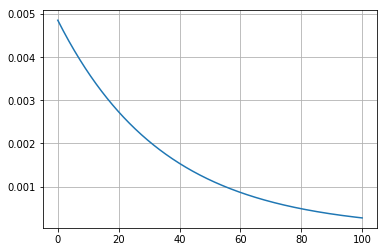

In [8]:
def calc_learning_rate(epoch):
    return 0.005 * math.pow(0.75, (1 + epoch) / 10)

epoch = np.linspace(0, 100, 500)
lrate = list(map(calc_learning_rate, epoch))
plt.plot(epoch, lrate);
plt.grid(True)

In [9]:
# def reset_weights(model):
#     session = K.get_session()
#     for layer in model.layers: 
#         if hasattr(layer, 'kernel_initializer'):
#             layer.kernel.initializer.run(session=session)

In [10]:
cb_learning_rate = LearningRateScheduler(calc_learning_rate)
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [11]:
def gen_model():
    model = Sequential([
        BatchNormalization(input_shape=(IMG_H, IMG_W, X_train.shape[-1]), axis=-1),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=0.3),
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# def gen_model():
#     model = Sequential([
#         BatchNormalization(input_shape=(IMG_H, IMG_W, 4), axis=-1),
#         Conv2D(filters=6, kernel_size=(5, 5), activation='relu', padding='same'),
#         MaxPooling2D(pool_size=(2, 2), padding='valid'),
#         Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='valid'),
#         MaxPooling2D(pool_size=(2, 2), padding='valid'),
#         Flatten(),
#         Dense(1024, activation='relu'),
#         Dense(NUM_CLASSES, activation='softmax')
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [ ]:
model = gen_model()

In [25]:
model.load_weights(r'0.88539\model_03.weights.h5')

history = model.fit_generator(
    aug_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    validation_data = (X_valid, Y_valid),
    epochs = NUM_EPOCHS + 50,
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
    # callbacks = [cb_learning_rate, cb_early_stopping],
    callbacks = [cb_learning_rate],
    verbose=1,
    initial_epoch=50
)

result = np.argmax(model.predict(X_test), axis=1)     

C:\Programs\Anaconda3\lib\site-packages\keras_preprocessing\image.py:1404: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4000, 28, 28, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 51/250
8/8 [==============================] - 3s 324ms/step - loss: 0.4720 - acc: 0.8312 - val_loss: 0.3897 - val_acc: 0.8613
Epoch 52/250
8/8 [==============================] - 3s 320ms/step - loss: 0.4854 - acc: 0.8268 - val_loss: 0.4081 - val_acc: 0.8627
Epoch 53/250
8/8 [==============================] - 3s 330ms/step - loss: 0.4819 - acc: 0.8293 - val_loss: 0.3838 - val_acc: 0.8587
Epoch 54/250
8/8 [==============================] - 3s 332ms/step - loss: 0.4600 - acc: 0.8380 - val_loss: 0.4171 - val_acc: 0.8440
Epoch 55/250
8/8 [==============================] - 3s 358ms/step - loss: 0.4810 - acc: 0.8308 - val_loss: 0.4359 - val_acc: 0.8480
Epoch 56/250
8/8 [==============================] - 3s 406ms/step - loss: 0.4729 - acc: 0.8253 - val_loss: 0.3632 - val_acc: 0.8600
Epoch 57/250
8/8 [==============================] - 3s 396ms/step - loss: 0.4822 - acc: 0.8293 - val_loss: 0.3806 - val_acc: 0.8627
Epoch 58/250
8/8 [==============================] - 3s 358ms/step - loss: 0.

Epoch 113/250
8/8 [==============================] - 4s 524ms/step - loss: 0.3416 - acc: 0.8788 - val_loss: 0.3104 - val_acc: 0.8933
Epoch 114/250
8/8 [==============================] - 4s 474ms/step - loss: 0.3271 - acc: 0.8810 - val_loss: 0.3068 - val_acc: 0.8933
Epoch 115/250
8/8 [==============================] - 3s 364ms/step - loss: 0.3369 - acc: 0.8750 - val_loss: 0.3016 - val_acc: 0.8920
Epoch 116/250
8/8 [==============================] - 3s 359ms/step - loss: 0.3405 - acc: 0.8762 - val_loss: 0.3144 - val_acc: 0.8840
Epoch 117/250
8/8 [==============================] - 3s 356ms/step - loss: 0.3361 - acc: 0.8713 - val_loss: 0.3093 - val_acc: 0.8933
Epoch 118/250
8/8 [==============================] - 3s 362ms/step - loss: 0.3367 - acc: 0.8810 - val_loss: 0.3067 - val_acc: 0.8920
Epoch 119/250
8/8 [==============================] - 3s 356ms/step - loss: 0.3288 - acc: 0.8820 - val_loss: 0.3019 - val_acc: 0.8920
Epoch 120/250
8/8 [==============================] - 3s 362ms/step - 

8/8 [==============================] - 3s 351ms/step - loss: 0.3183 - acc: 0.8825 - val_loss: 0.2931 - val_acc: 0.8960
Epoch 175/250
8/8 [==============================] - 3s 374ms/step - loss: 0.3045 - acc: 0.8893 - val_loss: 0.2909 - val_acc: 0.8947
Epoch 176/250
8/8 [==============================] - 3s 357ms/step - loss: 0.3111 - acc: 0.8843 - val_loss: 0.2927 - val_acc: 0.8947
Epoch 177/250
8/8 [==============================] - 3s 367ms/step - loss: 0.3156 - acc: 0.8845 - val_loss: 0.2965 - val_acc: 0.8960
Epoch 178/250
8/8 [==============================] - 3s 362ms/step - loss: 0.3078 - acc: 0.8893 - val_loss: 0.2947 - val_acc: 0.8987
Epoch 179/250
8/8 [==============================] - 3s 376ms/step - loss: 0.3205 - acc: 0.8888 - val_loss: 0.2944 - val_acc: 0.8947
Epoch 180/250
8/8 [==============================] - 3s 375ms/step - loss: 0.3173 - acc: 0.8855 - val_loss: 0.2953 - val_acc: 0.8933
Epoch 181/250
8/8 [==============================] - 4s 445ms/step - loss: 0.3152 -

Epoch 236/250
8/8 [==============================] - 3s 355ms/step - loss: 0.3000 - acc: 0.8903 - val_loss: 0.2966 - val_acc: 0.8960
Epoch 237/250
8/8 [==============================] - 3s 339ms/step - loss: 0.3221 - acc: 0.8827 - val_loss: 0.2966 - val_acc: 0.8947
Epoch 238/250
8/8 [==============================] - 3s 347ms/step - loss: 0.3218 - acc: 0.8830 - val_loss: 0.2969 - val_acc: 0.8947
Epoch 239/250
8/8 [==============================] - 3s 364ms/step - loss: 0.3230 - acc: 0.8803 - val_loss: 0.2966 - val_acc: 0.8973
Epoch 240/250
8/8 [==============================] - 3s 404ms/step - loss: 0.2999 - acc: 0.8930 - val_loss: 0.2964 - val_acc: 0.8973
Epoch 241/250
8/8 [==============================] - 3s 351ms/step - loss: 0.2969 - acc: 0.8942 - val_loss: 0.2969 - val_acc: 0.8973
Epoch 242/250
8/8 [==============================] - 3s 379ms/step - loss: 0.3091 - acc: 0.8928 - val_loss: 0.2972 - val_acc: 0.8973
Epoch 243/250
8/8 [==============================] - 3s 344ms/step - 

In [ ]:
# glob('test\*.png')[0].split('\\')[-1]

In [26]:
files = [path.split('\\')[-1] for path in glob('test\*.png')]
submit = pd.DataFrame({'file': files, 'species': le.inverse_transform(result)})

In [20]:
# submissions = pd.DataFrame({'ImageId': list(range(1, len(results1) + 1)), 'Label': results1})
# submissions.to_csv('kaggle_keras_09.2.csv', index=False, header=True)

In [27]:
submit.to_csv('model_05.csv', index=False)

In [28]:
model_json = model.to_json()
with open('model_05.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model_05.weights.h5')